The goal is modeling a scenario in which a seller exploits advertising tools to attract more and more users to its website, thus increasing the number of possible buyers. The seller needs to learn simultaneously the conversion rate and the number of users the advertising tools can attract.

1) Imagine:
    - one product to sell;
    - three classes of users, where, for every user, we can observe the values of two binary features (feel free to choose the features and their domains);
    - the conversion rate curve of each class of users;
    - three subcampaigns, each with a different ad, to advertise the product, and each targeting a different class of users;
    - there are three abrupt phases;
    - for every abrupt phase and for every subcampaign, the probability distribution over the daily number of clicks for every value of budget allocated to that subcampaign.

3) Design a sliding-window combinatorial bandit algorithm for the case, instead, in which there are the three phases aforementioned.
Plot the cumulative regret and compare it with the cumulative regret that a non-sliding-window algorithm would obtain.


9 curve, 3 fasi

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from project.Urbano08.AbruptBiddingEnvironment import AbruptBiddingEnvironment
from project.Urbano08.DynamicLearner import DynamicLearner
from project.Urbano08.Optimizer import Optimizer as Ta
import pandas as pd

In [2]:
n_phases = 3
len_window = 20
phaselen = 60
n_obs = 180 #3 abrupt phase
print_span = 30 #ogni quanti giorni printare i grafici

init_days = 20 #primi giorni si pullano gli arm in modo casuale senza pensare al reward massimo
random_sampling = 4

n_subcamp = 3

max_bid = 1
max_clicks = 100
n_arms = 11

noise_std = 5.0

bids = np.linspace(0, max_bid, n_arms)

total_click_each_day  = pd.DataFrame(columns=['bid_sub1', 'bid_sub2', 'bid_sub3',"click1","click2","click3"])


env = AbruptBiddingEnvironment(bids,max_clicks,noise_std,phaselen, n_phases)
learners = []

for i in range(0, n_subcamp):
    learners.append(DynamicLearner(n_arms,bids,len_window))

print(f'PHASES OF {env.phaselen} DAYS\n{n_obs} TOTAL OBSERVATION')

PHASES OF 60 DAYS
180 TOTAL OBSERVATION


DAY: 29
PULLED:[5, 3, 2]
CLICKS: [80.73092957 73.64772194 81.18933891]
TOT: 235.56799041671934

11
11
11
DAY: 59
PULLED:[4, 4, 2]
CLICKS: [86.14645667 82.62715672 89.87981188]
TOT: 258.6534252687795

11
11
11
DAY: 89
PULLED:[2, 0, 8]
CLICKS: [89.32169704  0.         59.95711913]
TOT: 149.2788161699167

11
11
11
DAY: 119
PULLED:[2, 5, 3]
CLICKS: [99.37416376 44.24605394 24.96614948]
TOT: 168.58636717322753

11
11
11
DAY: 149
PULLED:[3, 7, 0]
CLICKS: [93.15808479 70.74474354  0.        ]
TOT: 163.9028283280648

11
11
11
DAY: 179
PULLED:[3, 7, 0]
CLICKS: [98.04402552 66.87723695  0.        ]
TOT: 164.92126246988886

11
11
11


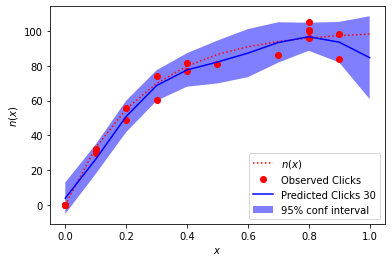

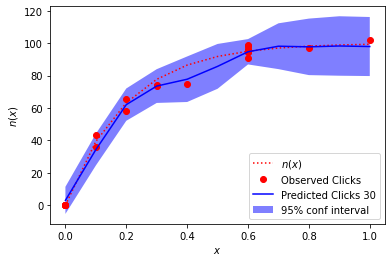

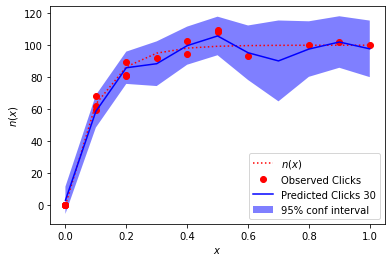

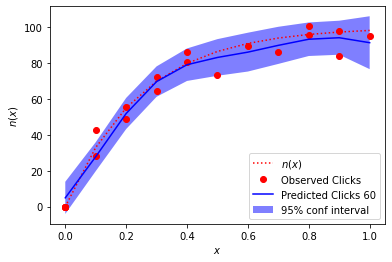

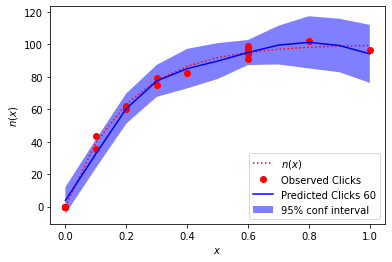

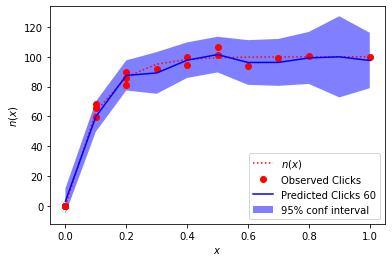

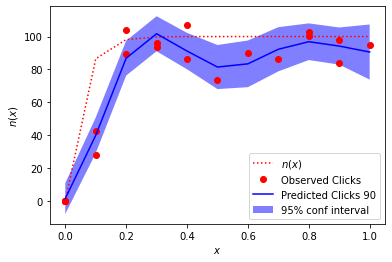

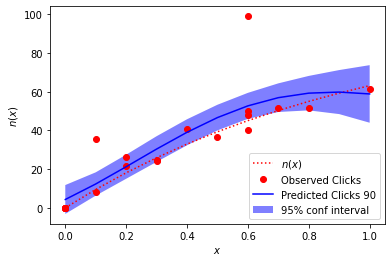

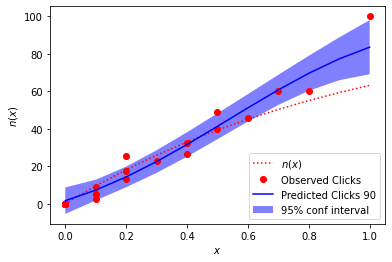

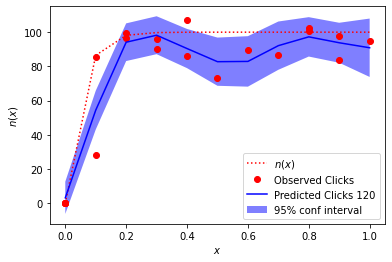

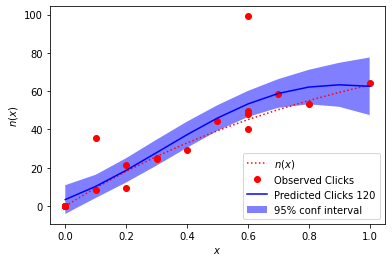

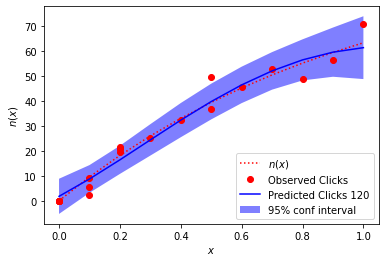

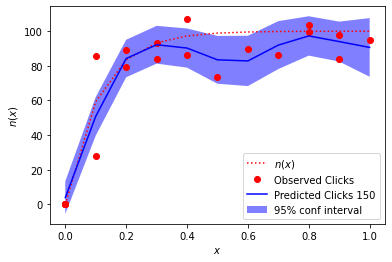

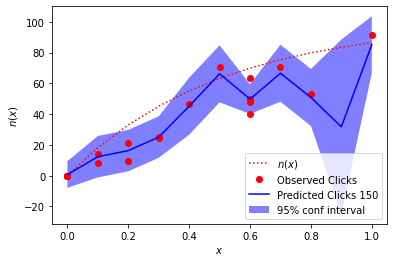

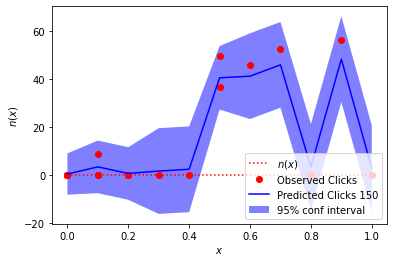

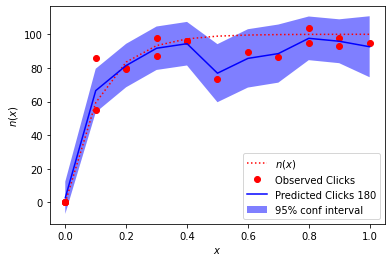

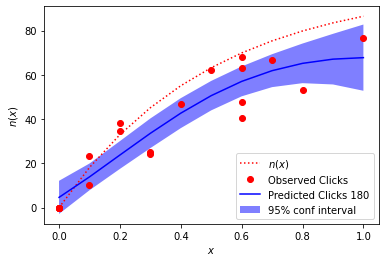

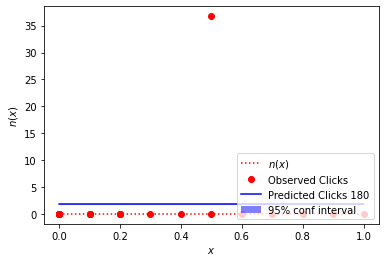

,bid_sub1,bid_sub2,bid_sub3,click1,click2,click3
0,3.0,6.0,1.0,72.150876,92.269353,56.284211
1,8.0,2.0,0.0,95.738050,69.151339,0.000000
2,1.0,0.0,9.0,28.791873,0.000000,101.863877
3,8.0,0.0,2.0,100.029208,0.000000,90.492251
4,4.0,6.0,0.0,78.284022,90.710729,0.000000
...,...,...,...,...,...,...
175,3.0,7.0,0.0,91.293107,71.018168,0.000000
176,1.0,2.0,7.0,54.840579,38.431024,0.000000
177,3.0,7.0,0.0,93.441074,77.286416,0.000000
178,3.0,7.0,0.0,87.261627,78.286036,0.000000


In [3]:
for d in range(0, n_obs):
    pulled = [0,0,0]
    #per i primi init_days giorni si pullano in modo causale, successivamente si usa la tabella
    if init_days > 0 or d % random_sampling == 0: #or d % int(len_window/2) == 0:
        init_days = init_days - 1
        first = d % 3
        pulled[first] = learners[first].pull_arm()
        pulled[(first + 1 )% 3] = np.random.randint(0,n_arms - pulled[first])
        pulled[(first + 2 )% 3] = n_arms - pulled[first] - pulled[(first + 1 )% 3] - 1
    else:
        #uso l'algoritmo della tabella per selezionare gli arm che mi danno un reward massimo
        table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
        for l in learners:
            table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)
        pulled = Ta.fit_table(table_all_Subs)[0]


    clicks = env.round(pulled[0],pulled[1],pulled[2])


    for x in range(0,n_subcamp):
        learners[x].update(pulled[x], clicks[x])
    total_click_each_day = total_click_each_day.append({
        'bid_sub1':pulled[0],
        'bid_sub2':pulled[1],
        'bid_sub3':pulled[2],
        "click1":clicks[0],
        "click2":clicks[1],
        "click3":clicks[2]
    }, ignore_index=True)

    if (d+1) % print_span == 0:
        #TIME TO PRINT THE PLOTS
        print(f"DAY: {d}\nPULLED:{pulled}\nCLICKS: {clicks}\nTOT: {clicks.sum()}\n")

        for l in range(0,len(learners)):
            learners[l].plot(env.subs[l])

total_click_each_day



